In [ ]:
# directly lidar2img and dense lidar

In [4]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset_lidar import CreateDatasets
from sensorFusionDataset.data_split import split_dataset
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder
from testLoop import test_loop
from trainLoop import train_loop
from visualization import plot_losses, plot_metrics,plotTraining
from earlystopping import EarlyStopping

import h5py as h5
from datetime import datetime
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import time

local_time =time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[-8:-1]
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
# CPU OR GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_path = 'image_gray_200_original'

lidar_mode = 'sparse'

if lidar_mode == 'sparse':
    lidar_path = 'lidar_tesor_200_sparse'
else:
    lidar_path = 'lidar_tesor_200_dense'

img_list = sorted(glob.glob(img_path + '/*'))[0:7200]
lidar_list = sorted(glob.glob(lidar_path + '/*'))[0:7200]

print(len(img_list),len(lidar_list))
batch_size = 32
learning_rate = 1e-4
epochs = 600

MyDataset = CreateDatasets(img_list, lidar_list)
train_dataset, test_dataset, val_dataset = split_dataset(MyDataset, 0.7, 0.2)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                          drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                         drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
                        drop_last=True)

# print(len(train_loader))

patience = 50	# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
save_path = 'model_save/'
early_stopping = EarlyStopping(save_path = save_path, patience = patience)	

new_model = SimpleAutoencoder()
new_model.to(device)
# new_model.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_300_32_20230516_205927.pth'))

# not fix the decoder
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
criterion = nn.MSELoss()
criterion.to(device)

training_loss = []
training_baseloss = []
test_loss = []
testing_baseloss = []
hisLrC = []
min_loss=10000

print (f'loading fertig! {device}' )

7200 7200
loading fertig! cuda


In [2]:
start_time = time.time()
for epoch in range(1, epochs + 1):
    # monitor training loss
    ##############################
    # start training the model #
    ##############################
    hisLrC.append(epoch)
    train_epoch_loss, train_epoch_baseloss = train_loop(train_loader, new_model, criterion, optimizer, device)
    training_loss.append(train_epoch_loss)
    # training_baseloss.append(train_epoch_baseloss)
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \t{:.0f}s'.format(epoch, epochs, train_epoch_loss,
                                                                  time.time() - start_time))

    ##############################
    # start testing the model #
    ##############################
    with torch.no_grad():
        test_epoch_loss, test_epoch_baseloss = test_loop(test_loader, new_model, criterion, device)
        test_loss.append(test_epoch_loss)
        # testing_baseloss.append(test_epoch_baseloss)
        
    # type(train_epoch_loss)) ---> float
    # writer.add_scalars('loss', {'training loss': train_epoch_loss, 'test loss': test_epoch_loss}, epoch)

        
    if test_epoch_loss < min_loss:
        min_loss = test_epoch_loss
        best_model_wts = copy.deepcopy(new_model.state_dict())
       

    if epoch == epochs:
        torch.save(best_model_wts, 'model_save/lidar2img/dense_noFIX_lidar2img_best_model_{}_{}_{}.pth'.format(epochs, batch_size,dt_string))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))     

    # 早停止
    date = dt_string
    early_stopping(test_epoch_loss, new_model, date)
    #达到早停止条件时，early_stop会被置为True
    if early_stopping.early_stop:
        torch.save(best_model_wts, 'model_save/lidar2img/dense_noFIX_lidar2img_best_model_{}_{}_{}.pth'.format(epochs, batch_size,dt_string))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))  
        print("Early stopping")
        break #跳出迭代，结束训练    
    
# train_baseline = sum(training_baseloss)/len(training_baseloss)
# test_baseline = sum(testing_baseloss)/len(training_baseloss)
# psnr_baseline = np.mean(psnr_base_list)

# train_baseline=train_baseline.item()
# test_baseline =test_baseline.item()
last_trainingloss = training_loss[-1]
last_testloss = test_loss[-1]


# write the dataset in one existed h5-file
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")

lossTrainArr = np.array(training_loss)
lossTestArr = np.array(test_loss)
bestLoss = np.array([min_loss])
LrCArr = np.array(hisLrC)

h5f =h5.File(f"log/recording_{dt_string}.hdf5","w")
# h5f = h5.File('train/train.h5', 'r+') # write in an exsited h5 file
g1 = h5f.create_group('log1')
g1.attrs['data']=now.strftime("%Y-%m-%d")
# g1.attrs['model']=ModelWts
# g1.attrs['optLrOrg']=str(optLrOrg)+'={:3.1e}'.format(optLrOrg) 
# g1.attrs['lrAdstep']= str(lrAdstep)
# g1.attrs['optimizer']= str(optimizer)[:4]

g1.create_dataset('lossTrain', data=lossTrainArr)
g1.create_dataset('lossTest', data=lossTestArr)
g1.create_dataset('bestLoss', data=bestLoss)
g1.create_dataset('LrCArr', data=LrCArr)
h5f.close()






Epoch: 1/600 	Training Loss: 2.777790 	136s
Epoch: 2/600 	Training Loss: 2.283023 	190s
Epoch: 3/600 	Training Loss: 2.212409 	211s
Epoch: 4/600 	Training Loss: 2.175349 	233s
Epoch: 5/600 	Training Loss: 2.172252 	254s
EarlyStopping counter: 1 out of 50
Epoch: 6/600 	Training Loss: 2.141073 	275s
Epoch: 7/600 	Training Loss: 2.137855 	296s
EarlyStopping counter: 1 out of 50
Epoch: 8/600 	Training Loss: 2.128691 	317s
Epoch: 9/600 	Training Loss: 2.125701 	338s
Epoch: 10/600 	Training Loss: 2.108860 	359s
EarlyStopping counter: 1 out of 50
Epoch: 11/600 	Training Loss: 2.107801 	381s
EarlyStopping counter: 2 out of 50
Epoch: 12/600 	Training Loss: 2.106803 	402s
Epoch: 13/600 	Training Loss: 2.099253 	423s
EarlyStopping counter: 1 out of 50
Epoch: 14/600 	Training Loss: 2.095054 	444s
Epoch: 15/600 	Training Loss: 2.089428 	466s
EarlyStopping counter: 1 out of 50
Epoch: 16/600 	Training Loss: 2.091579 	487s
EarlyStopping counter: 2 out of 50
Epoch: 17/600 	Training Loss: 2.087297 	508s

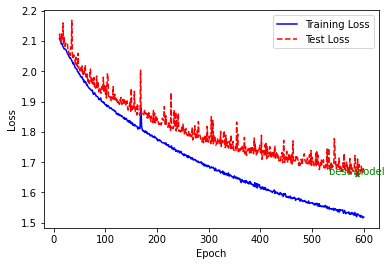

In [3]:
# # plot training and test
# f = h5.File('Experiment2_sequence_inverse/log/recording_20230509_232651.hdf5','r')

# lossTrainArr = f['log1']['lossTrain'][:]
# lossTestArr = f['log1']['lossTest'][:]
# bestLoss = f['log1']['bestLoss'][:]
# LrCArr = f['log1']['LrCArr'][:]

zoomin = 10
zoomout = 600
plotTraining(lossTrainArr, lossTestArr, LrCArr, bestLoss, zoomin, zoomout)

In [8]:

if lidar_mode == 'sparse':
    lidar_path = 'testdataset/lidar_tensor/sparse'
else:
    lidar_path = 'testdataset/lidar_tensor/dense'

label_path = 'testdataset/ori_image'

damaged_img_list = sorted(glob.glob(damaged_img_path + '/*'))
lidar_list = sorted(glob.glob(lidar_path + '/*'))
label_list = sorted(glob.glob(label_path + '/*'))

learning_rate = 1e-4
batch_size = 32

TestDataset = CreateDatasets(label_list, lidar_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

test_model_best = SimpleAutoencoder()
# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))
if lidar_mode == 'sparse':
    test_model_best.load_state_dict(torch.load('model_save/lidar2img/sparse_FIX_best_model_600_32_20230518_063828.pth'))
else:
    test_model_best.load_state_dict(torch.load('model_save/lidar2img/dense_FIX_best_model_600_32_20230518_154020.pth'))

    
# 01_sensor_fusion/Coding/sensorFusion/Experiment2_sequence_inverse/lidar2img_model/best_model_300_32_20230501_141654.pth

test_model_best.eval()

# obtain one batch of test images
dataiter = iter(new_testloader) # 22 batchse for validation
ori_img, noi_img = next(dataiter)

# get sample outputs
output = test_model_best(noi_img)

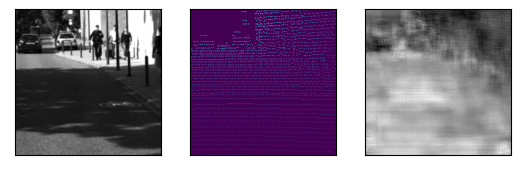

In [9]:
##################################################
# visualize one batch of the validation images #
##################################################
# test_model.to(device)


# prep images for display
# for i in range(ori_img.shape[0]):
for i in range(32):
    img1 = ori_img[i].numpy()
    img1 = img1.transpose(1, 2, 0)
    img2 = noi_img[i].numpy()
    img2 = img2.transpose(1, 2, 0)
    img3 = output[i].detach().numpy()
    img3 = img3.transpose(1, 2, 0)


    ax = plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('original image')
    plt.imshow(img1,cmap='gray')
    # plt.colorbar()


    ax = plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('noisy image')
    plt.imshow(img2)
    # plt.colorbar()

    # cmap='gray'
    ax = plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('denoised image')
    plt.imshow(img3,cmap='gray')
    # plt.colorbar()

    # plt.savefig('output_save/4_main_lidar2img_600/{}.png'.format(i))
# plt.show()

In [4]:
import cv2
from PIL import Image
from torchvision import transforms

##################################################
# visualize one batch of the validation images #
##################################################
# load the best/last model

test_model_best = SimpleAutoencoder()
test_model_best.load_state_dict(
    torch.load('model_save/lidar2img/3_lidar2img_best_model_600_32_20230518_154020.pth')
)


test_model_best.eval()
# obtain one batch of validation images
# for batch_index, dataiter in enumerate (val_loader)
dataiter = iter(val_loader)
# print (type(next(dataiter)))
ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter) # 2. batch


# get sample outputs

output = test_model_best(noi_img)


toPIL = transforms.ToPILImage()

# print(output.shape)
# prep images for display
for i in range(32):
    img1 = ori_img[i]
    img3 = output[i]
    # print(img1.shape, img3.shape)
    # print(type(img1),type(img3))
    # im1 = toPIL(img1)
    im3 = toPIL(img3)
    name = '%02d' %i

    # im1.save('output_save/ori_img/{}.png'.format(name))

    im3.save('output_save/4_main_lidar2img_reconstructed_600/{}.png'.format(name))

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [12]:
# MSE for all damages
criterion = nn.MSELoss()
criterion.to(device)

for i, batch in enumerate(new_testloader):# i -->index of batch
    count = 0
    for j in range (batch_size):
        img1 = ori_img[i]
        img3 = output[i]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,6)
    print(mse_mean)

1.981152
0.88336
2.99328
4.189536
0.850848
3.0064
0.78848
2.429184


In [14]:
# SSIM

import torch
from skimage.metrics import structural_similarity as ssim
import glob


metric_value_list = []
batch_size = 32


for i, batch in enumerate(new_testloader):
    label, lidar = batch
    count = 0
    for j in range(label.size(0)):
        ori_img_np = label[j][0].detach().cpu().numpy()
        output_np = output[j][0].detach().cpu().numpy()
        ssim_img, diff = ssim(ori_img_np, output_np, full=True, data_range=1.0)
        count = count + ssim_img
    ssim_img = round(count / label.size(0), 3)
    print(ssim_img)
#     metric_value_list.append(ssim_img)

# print(metric_value_list)

0.315
0.28
0.276
0.271
0.246
0.273
0.265
0.271


In [8]:
print(round(sum(metric_value_list)/len(metric_value_list),6))

0.328182


In [16]:
# LLIPS metrics

import lpips

loss_fn = lpips.LPIPS(net='alex')


for i, batch in enumerate(new_testloader):  # i -->index of batch
    label, lidar = batch
    count = 0
    lpips_img = loss_fn.forward(label, output)
    sum_result = (torch.sum(lpips_img)).item()
    lpips_img = round(sum_result/label.size(0),3)
    print(lpips_img)
#     metric_value_list.append(lpips_img)

# print(f'scuccess: {metric_value_list}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/Anaconda3-2021.11-Linux-x86_64/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
0.58
0.603
0.611
0.614
0.625
0.618
0.618
0.625
